In [2]:
library(ggplot2)
library(dplyr)
library(readr)
library(tidyr)

### Outliers

In [2]:
df <- read_csv('../data/diabetes_012_health_indicators_BRFSS2015.csv')

Rows: 253680 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gom nhóm nhãn hiếm cho Education.       
1: Less than high school.       
2: High School.     
3: College.     
4: College gradute. 

In [3]:
df <- df %>%
  mutate(Education = case_when(
    Education %in% c(1,2,3) ~ 1,
    Education %in% c(4,5,6) ~ Education
  )) %>%
  mutate(Education = factor(Education, levels = c(1,4,5,6), labels = c(1,2,3,4)))

df$Education <- as.double(as.character(df$Education))

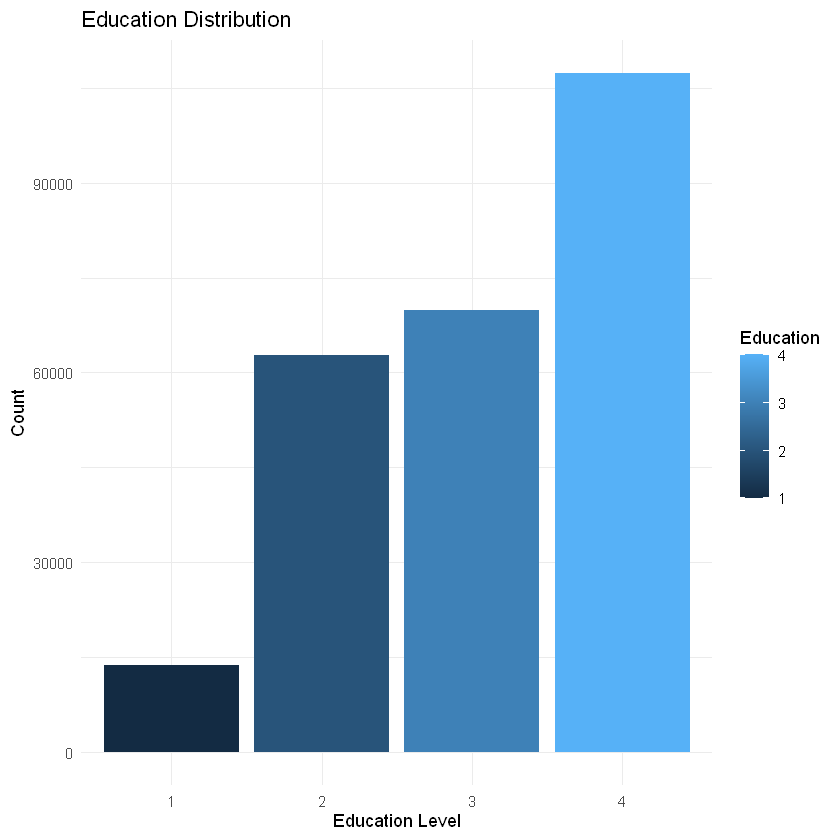

In [4]:
ggplot(df, aes(x=as.factor(Education), fill=Education)) +
    geom_bar() +
    labs(title = "Education Distribution",
         x = "Education Level",
         y = "Count") +
    theme_minimal() 

Scale lại dữ liệu cho các biến định lượng để giảm ảnh hưởng của outliers. 

In [5]:
robust_scaler <- function(x) {
  Q1 <- quantile(x, 0.25) 
  Q3 <- quantile(x, 0.75) 
  IQR <- Q3 - Q1          
  median_x <- median(x)   

  scaled_x <- (x - median_x) / IQR
  return(scaled_x)
}

df <- df %>%
  mutate(BMI = robust_scaler(BMI)) %>%
  mutate(PhysHlth = robust_scaler(PhysHlth)) %>%
  mutate(MentHlth = robust_scaler(MentHlth))

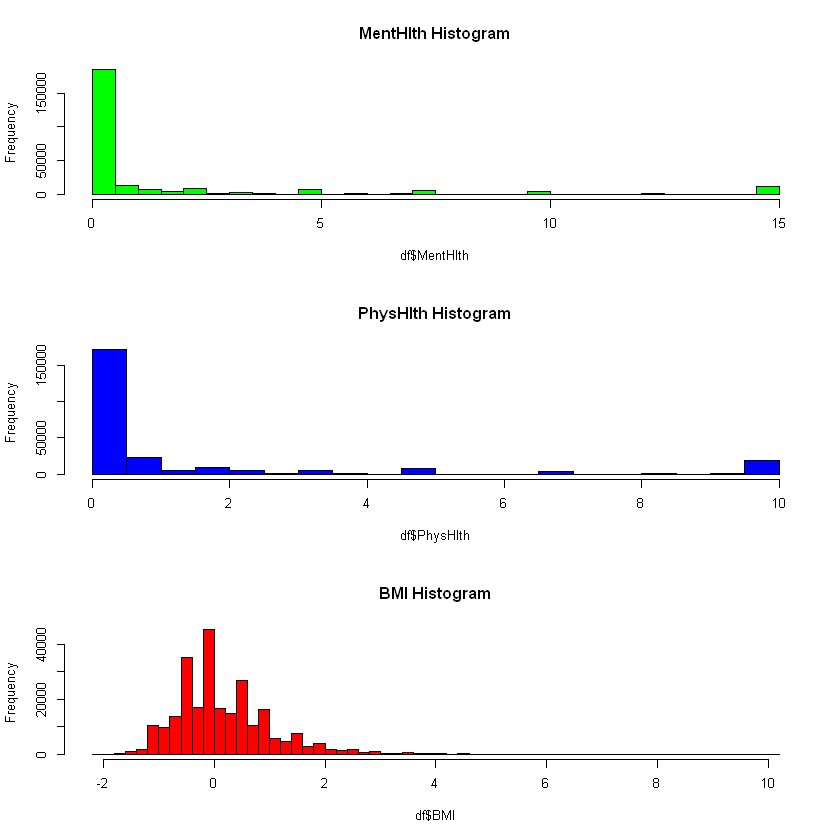

In [6]:
# plot the distribution of BMI, PhysHlth, and MentHlth
par(mfrow=c(3,1), bg='white')
hist(df$MentHlth, breaks=31, col='green', main='MentHlth Histogram')
hist(df$PhysHlth, breaks=31, col='blue', main='PhysHlth Histogram')
hist(df$BMI, breaks=84, col='red', main='BMI Histogram')

In [8]:
write.csv(df, '../data/clean_outliers.csv', row.names=FALSE)

### Imbalanced 

In [3]:
df <- read.csv('../data/clean_outliers.csv')

In [4]:
# split the data into training and testing sets
set.seed(345)
train_index <- sample(1:nrow(df), 0.7*nrow(df))
train <- df[train_index,]
test <- df[-train_index,]

In [5]:
with(train, table(Diabetes_012))

Diabetes_012
     0      1      2 
149578   3232  24766 

kiểm tra số lượng các quan trắc duy nhất trong nhóm tiền tiểu đường 

In [ ]:
with(train %>% distinct(), table(Diabetes_012))

Diabetes_012
     0      1      2 
135618   3232  24643 

In [7]:
with(test, table(Diabetes_012))

Diabetes_012
    0     1     2 
64125  1399 10580 

In [6]:
write.csv(train, '../data/training_sets/train_base.csv', row.names=FALSE)

In [13]:
write.csv(test, '../data/testset.csv', row.names=FALSE)

Under Sampling 

In [14]:
under_sampling_3c <- function(data, name_class) {
    class_fact <- as.factor(data[, name_class])
    data_split <- split(data, class_fact)
    n_class <- sapply(data_split, FUN = nrow)
    n_minor <- min(n_class)
    
    new_data <- do.call(rbind, lapply(data_split, function(class_data) {
        id_sample <- sample(1:nrow(class_data), size = n_minor, replace = FALSE)
        class_data[id_sample, ]
    }))
    
    return(new_data)
}


In [15]:
set.seed(345)
train_under <- under_sampling_3c(train, "Diabetes_012")
with(train_under, table(Diabetes_012))

Diabetes_012
   0    1    2 
3232 3232 3232 

In [16]:
# save the under-sampled data to csv 
write.csv(train_under, '../data/training_sets/train_under.csv', row.names=FALSE)

Over Sampling

In [17]:
over_sampling_3c <- function(data, name_class) {
    class_fact <- as.factor(data[, name_class])
    data_split <- split(data, class_fact)
    n_class <- sapply(data_split, FUN = nrow)
    n_major <- max(n_class)
    
    new_data <- do.call(rbind, lapply(data_split, function(class_data) {
        id_sample <- sample(1:nrow(class_data), size = n_major, replace = TRUE)
        class_data[id_sample, ]
    }))
    
    return(new_data)
}

In [18]:
set.seed(345)
train_over <- over_sampling_3c(train, "Diabetes_012")
with(train_over, table(Diabetes_012))

Diabetes_012
     0      1      2 
149578 149578 149578 

In [19]:
write.csv(train_over, '../data/training_sets/train_over.csv', row.names=FALSE)

Under + Over Sampling

In [20]:
# kết hợp under sampling và over sampling cho 3 classes
combine_sampling_3c <- function(data, name_class) {
    class_fact <- as.factor(data[, name_class])
    data_split <- split(data, class_fact)
    n_class <- sapply(data_split, FUN = nrow)
    
    # xác định cỡ mẫu chung cho các class (avg)
    n_avg <- round(mean(n_class))

    new_data <- do.call(rbind, lapply(data_split, function(class_data) {
        n_class_data <- nrow(class_data)
        if (n_class_data < n_avg) {
            id_sample <- sample(1:n_class_data, size = n_avg - n_class_data, replace = TRUE)
            class_data <- rbind(class_data, class_data[id_sample, ])
        } else {
            id_sample <- sample(1:n_class_data, size = n_avg, replace = FALSE)
            class_data <- class_data[id_sample, ]
        }
        return(class_data)
    }))
    
    return(new_data)
}

In [21]:
set.seed(345)
train_combine <- combine_sampling_3c(train, "Diabetes_012")
with(train_combine, table(Diabetes_012))

Diabetes_012
    0     1     2 
59192 59192 59192 

In [22]:
write.csv(train_combine, '../data/training_sets/train_combine.csv', row.names=FALSE)

SMOTE

In [23]:
library(themis)

Loading required package: recipes


Attaching package: 'recipes'


The following object is masked from 'package:stats':

    step




In [24]:
train$Diabetes_012 <- as.factor(train$Diabetes_012)
set.seed(345)
train_smote <- smotenc(df= train, var = "Diabetes_012", k = 5, over_ratio = 1)

In [25]:
with(train_smote, table(Diabetes_012))

Diabetes_012
     0      1      2 
149578 149578 149578 

In [26]:
write.csv(train_smote, '../data/training_sets/train_smote.csv', row.names=FALSE)